In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
vol_file = '../Analysis/depreciated/analysis_sections_ablation.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_len = t_pre+t_post
t_sig = 300 # time used for significance test after swim
non_spike_thres = 100
k_spk = boxcarKernel(sigma=61)
k_sub = 10

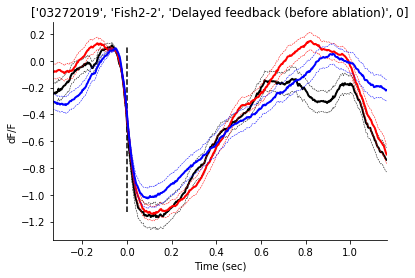

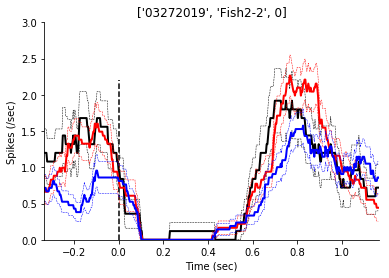

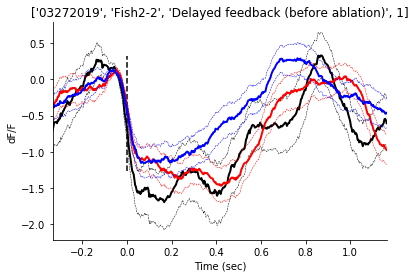

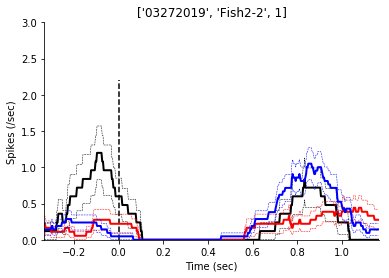

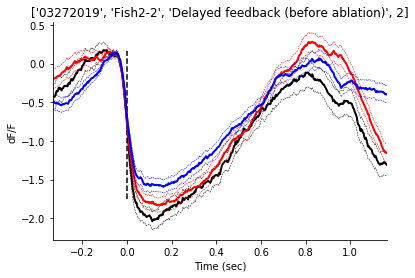

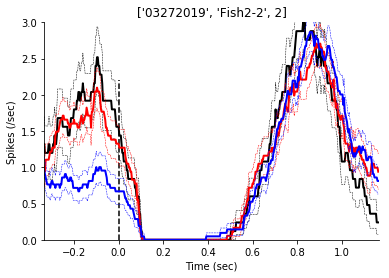

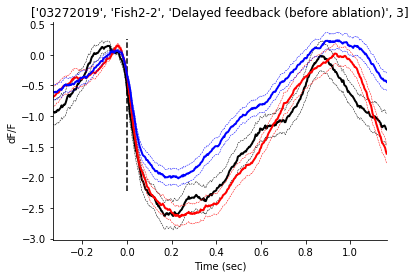

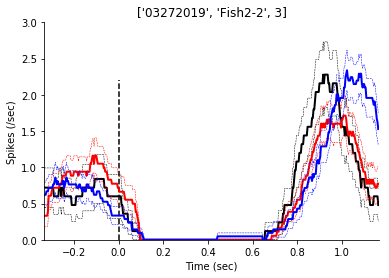

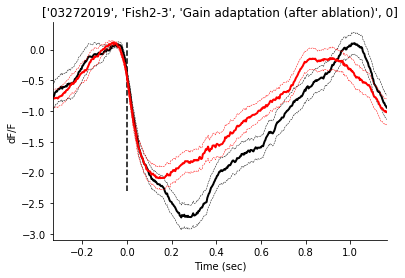

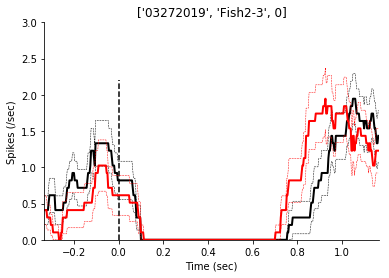

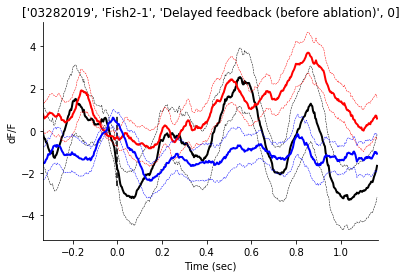

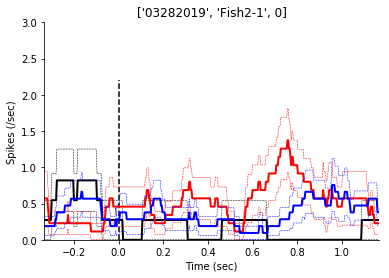

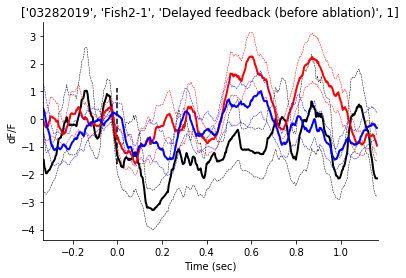

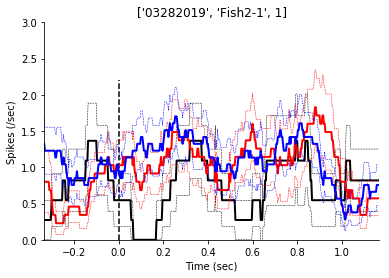

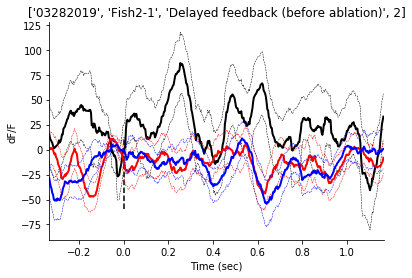

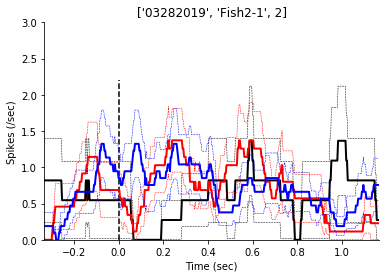

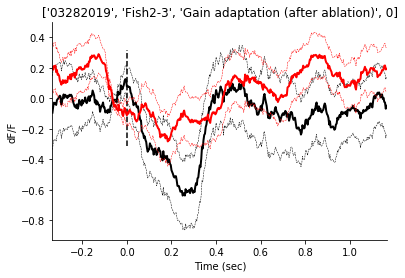

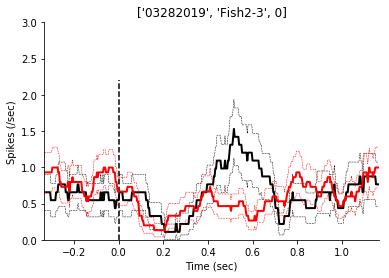

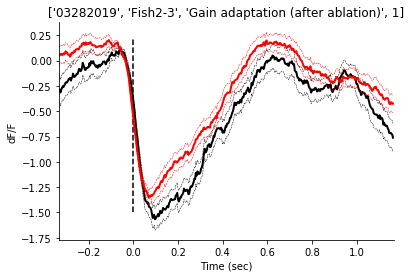

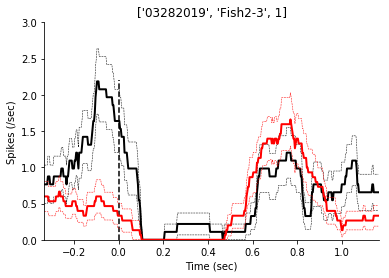

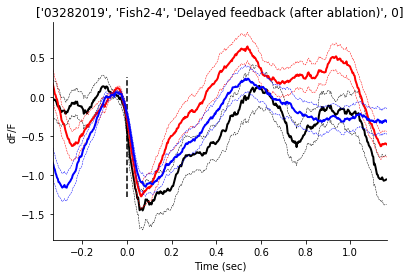

In [ ]:
valid_ind = np.zeros(len(dat_xls_file)).astype('bool')

for ind, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    p_swim = np.sqrt(r_swim**2+l_swim**2)
    
    trial_valid_ = np.ones(len(swim_starts)).astype('bool')
    for n, n_swim in enumerate(swim_starts[:-1]):        
        # examine the swim with short inter-swim-interval
        if swim_starts[n+1] - n_swim < t_sig:    
            trial_valid_[n] = False

    n_task = task_period.max().astype('int')
    swim_task_index_ = (swim_task_index-1)%n_task+1
    swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
    swim_bout_index_task[0] = 1
    for n_bout in range(len(swim_task_index_)-1):
        if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
            swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
        else:
            swim_bout_index_task[n_bout] = 1
            
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    sub_sig_swim = _['sub_sig_swim']
    trial_valid = _['trial_valid']
    
    
    for n_cell in range(sub_swim.shape[0]):
        sub_sig = sub_sig_swim[n_cell]
        sub_list = sub_swim[n_cell]
        sub_list = sub_list - sub_list[:, (t_pre-30):t_pre].mean(axis=-1, keepdims=True)
        spk_list = spk_swim[n_cell]
        
#         if (sub_sig<0.05).mean()<0.3:
#             continue
        
#         valid_ind[ind] = True
        
        ave_ = sub_list[(task_period==1) & trial_valid, :]*100
        mean_ = np.nanmean(ave_, axis=0)
        max_ = mean_.max()
        min_ = mean_.min()
        std_ = sem(ave_, axis=0, nan_policy='omit')
        plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2)
        plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
        plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)
        
        ave_ = sub_list[(task_period==2) & trial_valid, :]*100
        mean_ = np.nanmean(ave_, axis=0)
        max_ = mean_.max()
        min_ = mean_.min()
        std_ = np.nanstd(ave_, axis=0)/np.sqrt(ave_.shape[0])
        plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2)
        plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
        plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)
        
        if task_period.max()==3:
            ave_ = sub_list[(task_period==3) & trial_valid, :]*100
            mean_ = np.nanmean(ave_, axis=0)
            max_ = mean_.max()
            min_ = mean_.min()
            std_ = np.nanstd(ave_, axis=0)/np.sqrt(ave_.shape[0])
            plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-b', lw=2)
            plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--b', lw=0.5)
            plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--b', lw=0.5)

        # plt.ylim([0, 2.2])
        plt.xlim([-t_pre/300, t_post/300])
        plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
        plt.xlabel('Time (sec)')
        plt.ylabel('dF/F')
        sns.despine()
        plt.title([folder, fish, task_type, n_cell])
        plt.show()
        
        ave_ = spk_list[(task_period==1) & trial_valid, :]*300
        mean_ = ave_.mean(axis=0)
        std_ = ave_.std(axis=0)/np.sqrt(ave_.shape[0])
        plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2)
        plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
        plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)
        
        ave_ = spk_list[(task_period==2) & trial_valid, :]*300
        mean_ = ave_.mean(axis=0)
        std_ = ave_.std(axis=0)/np.sqrt(ave_.shape[0])
        plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2)
        plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
        plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)
        
        if task_period.max()==3:
            ave_ = spk_list[(task_period==3) & trial_valid, :]*300
            mean_ = ave_.mean(axis=0)
            std_ = ave_.std(axis=0)/np.sqrt(ave_.shape[0])
            plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-b', lw=2)
            plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--b', lw=0.5)
            plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--b', lw=0.5)
        plt.ylim([0, 3])
        plt.xlim([-t_pre/300, t_post/300])
        plt.vlines([0], [0], [2.2], colors='k', linestyles='--')
        plt.xlabel('Time (sec)')
        plt.ylabel('Spikes (/sec)')
        sns.despine()
        plt.plot()       
        plt.title([folder, fish, n_cell])
        plt.show()

In [4]:
# for _, row in dat_xls_file.iterrows():
#     if 'Social' in row['task']:
#         continue
#     if 'Optovin' in row['task']:
#         continue
#     folder = row['folder']
#     fish = row['fish']
    
#     _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
#     swim_starts = _['swim_starts']
#     swim_ends = _['swim_ends']
#     r_swim = _['r_swim']
#     l_swim = _['l_swim']
#     visu = _['visu']
#     task_period = _['task_period']
#     swim_task_index = _['swim_task_index']
#     p_swim = np.sqrt(r_swim**2+l_swim**2)

#     n_task = task_period.max().astype('int')
#     swim_task_index_ = (swim_task_index-1)%n_task+1
#     swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
#     swim_bout_index_task[0] = 1
#     for n_bout in range(len(swim_task_index_)-1):
#         if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
#             swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
#         else:
#             swim_bout_index_task[n_bout] = 1
            
#     _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
#     sub_swim = _['sub_swim']
#     spk_swim = _['spk_swim']
#     sub_sig_swim = _['sub_sig_swim']
#     # trial_valid = _['trial_valid']
    
#     swim_len = swim_ends - swim_starts
#     swim_power = np.zeros(len(swim_len))
#     for n_ in range(len(swim_len)):
#         swim_power[n_] = p_swim[n_, t_pre:(t_pre+swim_len[n_])].mean()
    
#     power_range = np.percentile(swim_power[task_period==2], [70, 80])
#     trial_valid = (swim_power>power_range[0]) & (swim_power<power_range[1])
    
#     plt.plot(np.arange(-t_pre, t_post)/300, p_swim[trial_valid & (task_period==1), :].mean(axis=0), '-k')
#     plt.plot(np.arange(-t_pre, t_post)/300, p_swim[trial_valid & (task_period==2), :].mean(axis=0), '-r')
#     plt.show()
    
        
#     for n_cell in range(sub_swim.shape[0]):
#         sub_sig = sub_sig_swim[n_cell]
#         sub_list = sub_swim[n_cell]
#         sub_list = sub_list - sub_list[:, (t_pre-30):t_pre].mean(axis=-1, keepdims=True)
#         spk_list = spk_swim[n_cell]
        
#         if (sub_sig<0.05).mean()<0.4:
#             continue

#         ave_ = sub_list[(task_period==1) & trial_valid, :]*100
#         mean_ = np.nanmean(ave_, axis=0)
#         max_ = mean_.max()
#         min_ = mean_.min()
#         std_ = sem(ave_, axis=0, nan_policy='omit')
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2)
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)
        
#         ave_ = sub_list[(task_period==2) & trial_valid, :]*100
#         mean_ = np.nanmean(ave_, axis=0)
#         max_ = mean_.max()
#         min_ = mean_.min()
#         std_ = np.nanstd(ave_, axis=0)/np.sqrt(ave_.shape[0])
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2)
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)

#         # plt.ylim([0, 2.2])
#         plt.xlim([-t_pre/300, t_post/300])
#         plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
#         plt.xlabel('Time (sec)')
#         plt.ylabel('dF/F')
#         sns.despine()
#         plt.title([folder, fish, n_cell])
#         plt.show()
        
#         ave_ = spk_list[(task_period==1) & trial_valid, :]*300
#         mean_ = ave_.mean(axis=0)
#         std_ = ave_.std(axis=0)/np.sqrt(ave_.shape[0])
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2)
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)
        
#         ave_ = spk_list[(task_period==2) & trial_valid, :]*300
#         mean_ = ave_.mean(axis=0)
#         std_ = ave_.std(axis=0)/np.sqrt(ave_.shape[0])
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2)
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
#         plt.plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)
#         plt.ylim([0, 2.2])
#         plt.xlim([-50/300, 250/300])
#         plt.vlines([0], [0], [2.2], colors='k', linestyles='--')
#         plt.xlabel('Time (sec)')
#         plt.ylabel('Spikes (/sec)')
#         sns.despine()
#         plt.plot()       
#         plt.title([folder, fish, n_cell])
#         plt.show()